# E-Commerce project with neural networks model

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# get data

df = pd.read_csv("ecommerce_data.csv")
df.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


### preprocessing data

In [23]:
def get_data():
    df = pd.read_csv("ecommerce_data.csv")
    # easier to work with numpy arrays
    data = df.to_numpy()
    # shuffle the data
    np.random.shuffle(data)
    # split features and labels
    X = data[:, :-1]
    Y = data[:, -1].astype(np.int32)
    
    # one-hot encode time of day column
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    # non-categorical columns
    X2[:, :(D-1)] = X[:, :(D-1)]
    # categorical column
    for n in range(N):
        t = int(X[n, D-1])
        X2[n, t+D-1] = 1
        
    # assign X2 back to X
    X = X2
    
    # split train and test
    Xtrain = X[:-100]
    Ytrain = Y[:-100]
    Xtest = X[-100:]
    Ytest = Y[-100:]
    
    # normalize columns 1 and 2
    for i in (1,2):
        m = Xtrain[:, i].mean()
        s = Xtrain[:, i].std()
        Xtrain[:, i] = (Xtrain[:, i] - m)/s
        Xtest[:, i] = (Xtest[:, i] - m)/s
    return Xtrain, Ytrain, Xtest, Ytest
    
    

In [24]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

In [25]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((400, 8), (400,), (100, 8), (100,))

### random predictions with neural networks

In [11]:
X, Y, _, _ = get_data()

In [12]:
# randomly initialize weights
# size of hidden layer is M
M = 5
D = X.shape[1]
K = len(set(Y))

W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)



In [13]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

In [14]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2)

In [15]:
P_Y_given_X = forward(X, W1, b1, W2, b2)

In [16]:
P_Y_given_X.shape

(400, 4)

In [17]:
predictions = np.argmax(P_Y_given_X, axis=1)

In [18]:
predictions[:10]

array([1, 0, 0, 3, 3, 2, 0, 0, 0, 3])

In [19]:
def classification_rate(Y, P):
    return np.mean(Y == P)

In [20]:
classification_rate(Y, predictions)

0.3125

### training for logistic model with softmax classification

In [30]:
# this function will one-hot encode the targets
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind
    

In [27]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

In [28]:
D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))

In [31]:
# convert targets to indicator
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

In [32]:
# randomly initialize weights
W = np.random.randn(D, K)
b = np.zeros(K)

In [33]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

In [34]:
def forward(X, W, b):
    return softmax(X.dot(W) + b)

In [35]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

In [36]:
def classification_rate(Y, P):
    return np.mean(Y == P)

In [37]:
def cross_entropy(Y, pY):
    return - np.mean(Y * np.log(pY))

In [38]:
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10_000):
    pYtrain = forward(Xtrain, W, b)
    pYtest = forward(Xtest, W, b)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    #gradient descent
    W -= learning_rate * Xtrain.T.dot(pYtrain - Ytrain_ind)
    b -= learning_rate * (pYtrain - Ytrain_ind).sum(axis=0)
    
    if i%1000 == 0:
        print(i, ctrain, ctest)

0 0.7082765458268294 0.7794234023918832
1000 0.08452148743517647 0.10562470006278693
2000 0.08023034858210146 0.10240786942008033
3000 0.07867428469608534 0.1015704820754228
4000 0.07790906073905149 0.10130441784404434
5000 0.07747011267543537 0.10122901257302054
6000 0.07719354757450166 0.10122761017190054
7000 0.07700793687806591 0.10125648371347275
8000 0.07687758304939289 0.10129719898323306
9000 0.0767828417541408 0.10134144216997011


In [39]:
acc_train = classification_rate(Ytrain, predict(pYtrain))
print("Final train classification rate:", acc_train)
acc_test = classification_rate(Ytest, predict(pYtest))
print("Final test classification rate:", acc_test)

Final train classification rate: 0.9225
Final test classification rate: 0.92


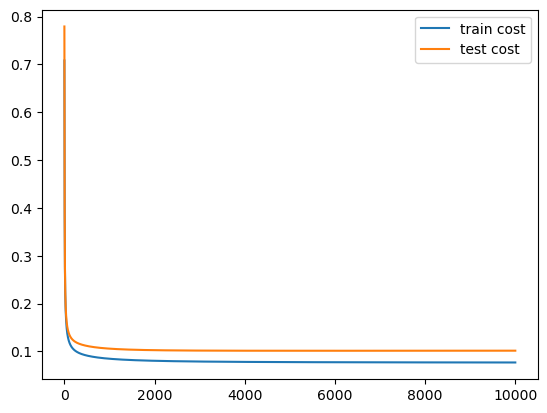

In [40]:
plt.plot(train_costs, label='train cost')
plt.plot(test_costs, label="test cost")
plt.legend();

### training the neural network model

In [41]:
# function to one-hot encode the targets
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [42]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

In [43]:
D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))
M = 5

In [44]:
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

In [45]:
# randomly initialize weights
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

In [46]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

In [47]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z

In [48]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

In [49]:
def classification_rate(Y, P):
    return np.mean(Y == P)

In [50]:
def cross_entropy(Y, pY):
    return -np.mean(Y * np.log(pY))

In [51]:
# training loop
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10_000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    # gradient descent
    gW2 = Ztrain.T.dot(pYtrain - Ytrain_ind)
    gb2 = (pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain * Ztrain)
    gW1 = Xtrain.T.dot(dZ)
    gb1 = dZ.sum(axis=0)
    
    W2 -= learning_rate * gW2
    b2 -= learning_rate * gb2
    W1 -= learning_rate * gW1
    b1 -= learning_rate * gb1
    
    if i%1000 == 0:
        print(i, ctrain, ctest)

0 0.5501570366840483 0.6196313463579627
1000 0.03389628357939252 0.040325076998795645
2000 0.025324760770320167 0.034668877603796826
3000 0.021773100269185424 0.0332857783624346
4000 0.019658506670341466 0.03321761515866191
5000 0.018236102634793472 0.03368329171950612
6000 0.01715540097372549 0.034040313100841
7000 0.016229991628572936 0.034024383753731346
8000 0.015354698458848418 0.033476536916901806
9000 0.01451012258148316 0.03247912130709604


In [52]:
pYtrain, _ = forward(Xtrain, W1, b1, W2, b2)
pYtest, _ = forward(Xtest, W1, b1, W2, b2)

acc_train = classification_rate(Ytrain, predict(pYtrain))
print("Final train classification rate:", acc_train)
acc_test = classification_rate(Ytest, predict(pYtest))
print("Final test classification rate:", acc_test)

Final train classification rate: 0.975
Final test classification rate: 0.94


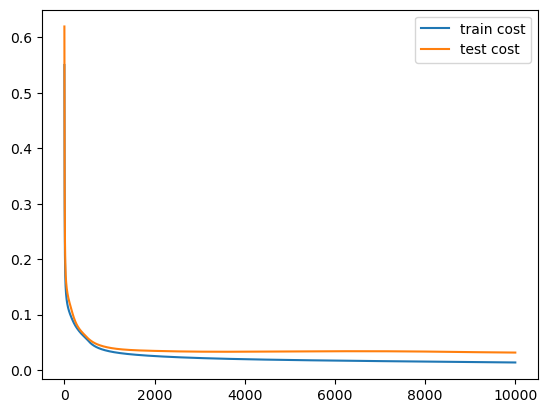

In [53]:
plt.plot(train_costs, label='train cost')
plt.plot(test_costs, label="test cost")
plt.legend();